# MNIST for online classification

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import keras
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from functools import partial
from jax.flatten_util import ravel_pytree

from methods import low_rank_filter_revised as lrkf
from methods import low_rank_last_layer as hilofi
from methods import low_rank_filter as lofi
from methods import replay_sgd

In [4]:
sns.set_palette("colorblind")

In [5]:
%config InlineBackend.figure_format = "retina"

## Load dataset

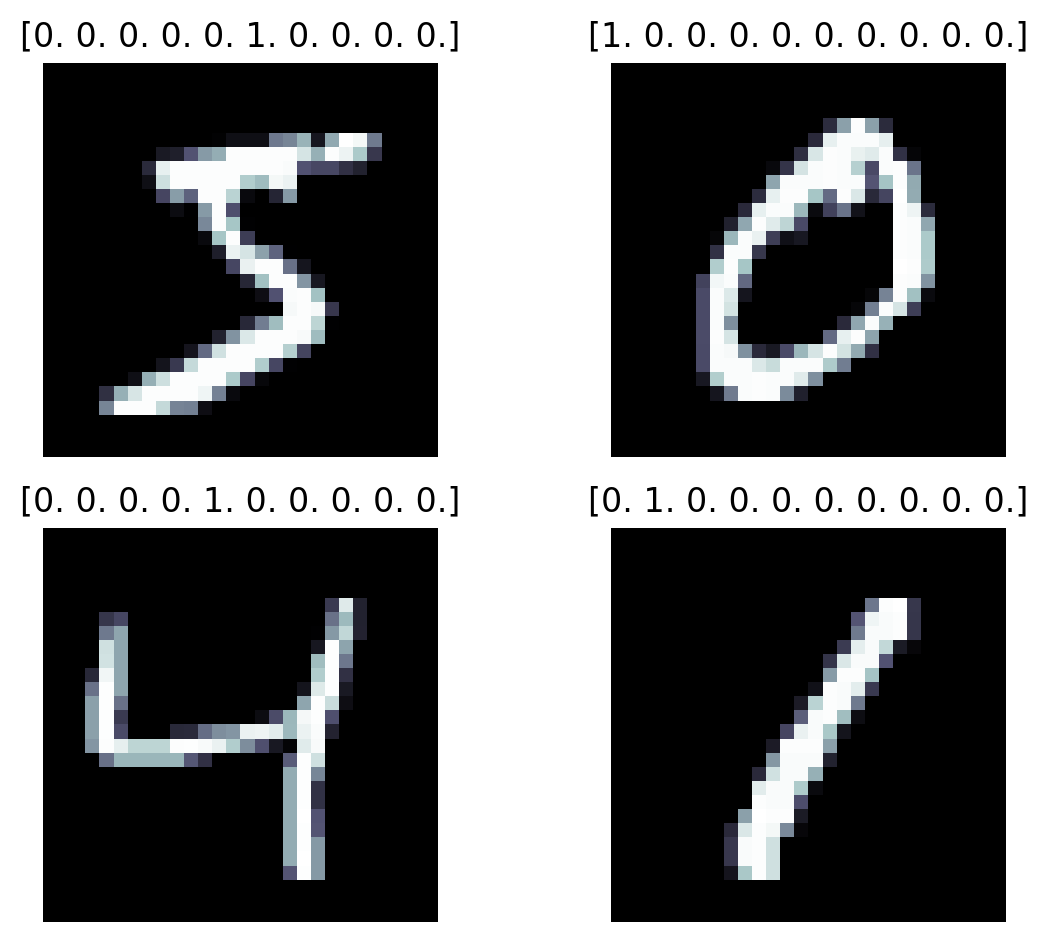

In [6]:
# (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X_train[i], cmap="bone")
    ax.set_title(y_train[i])
    ax.axis("off")
plt.tight_layout()

## Train

In [7]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]

In [8]:
class CNN(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.elu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.elu(x)
        x = nn.Dense(features=84)(x)
        x = nn.elu(x)
        x = nn.Dense(10, name="last_layer")(x)
        return x.squeeze()

model = CNN()

In [9]:
def plot_err_bound(df, ax, label, periods=5000, min_periods=None):
    min_periods = periods if min_periods is None else min_periods
    df.rolling(periods, min_periods=min_periods).mean().mean(axis=1).plot(label=label, ax=ax)

## Revised version

In [10]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.predict_fn(bel_pred, x)
    acc = y.argmax() == yhat.argmax()
    return (acc,)

In [11]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.1):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [14]:
n_sims = 10
keys = jax.random.PRNGKey(314)
keys = jax.random.split(keys, n_sims)
model = CNN()

In [15]:
n_obs = len(X_train)

In [16]:
%%time

def run_lrkf(key, rank=20):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    params = model.init(key_init, X_train[:1])
    agent = lrkf.LowRankCovarianceFilter(
        mean_fn,
        cov_fn,
        dynamics_covariance=0.01,
        rank=rank,
    )
    bel_init = agent.init_bel(params, cov=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lrkf = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_lrkf

hist_lrkf = jax.vmap(run_lrkf)(keys)
hist_lrk = jax.tree.map(np.array, hist_lrkf)

CPU times: user 49.5 s, sys: 340 ms, total: 49.8 s
Wall time: 3min 4s


In [17]:
df_lrkf = pd.DataFrame(hist_lrkf[0].T)
df_lrkf.shape

(60000, 10)

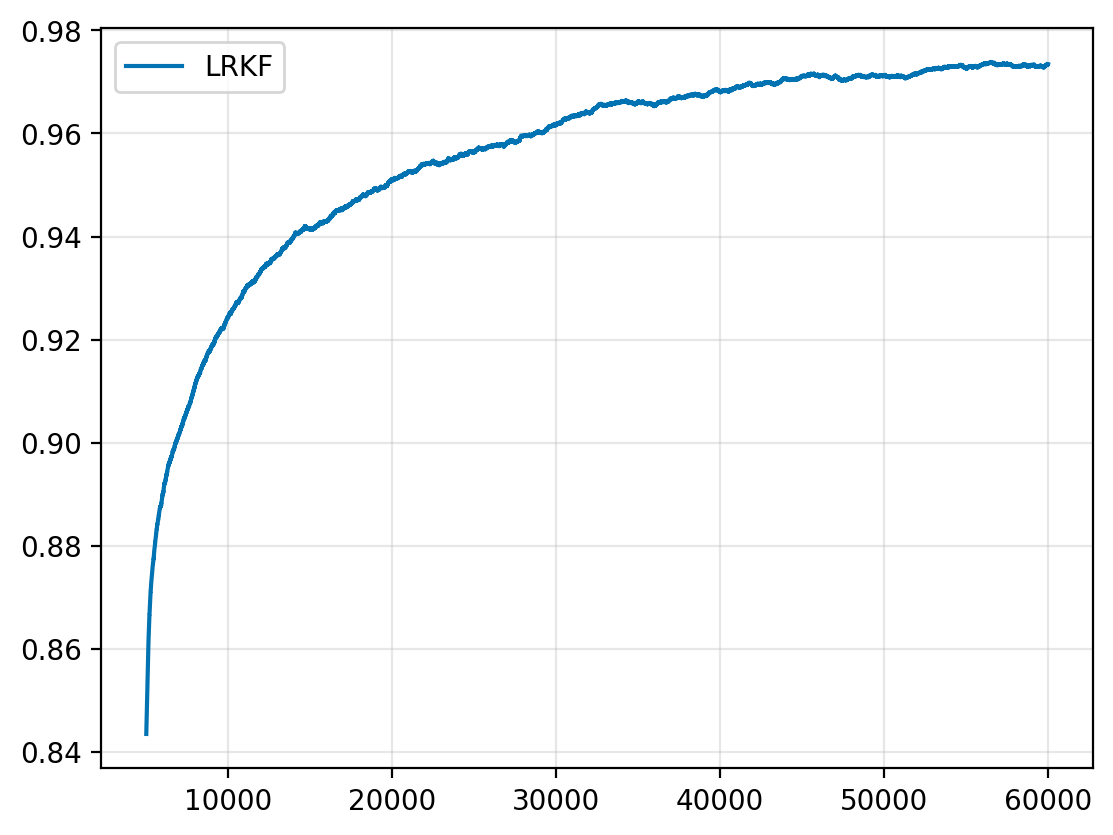

In [18]:
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plt.legend()
plt.grid(alpha=0.3)

# LoLoFi

In [19]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.predict_fn(bel_pred, x)
    acc = y.argmax() == yhat.argmax()
    return acc

In [20]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=1e-4):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [23]:
%%time
def run_lolofi(key, rank=100):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = hilofi.LowRankLastLayer(
        mean_fn, cov_fn, rank=rank, rank_last=50,
        # dynamics_hidden=1e-6, dynamics_last=1e-6,
        dynamics_hidden=0.01, dynamics_last=0.01,
    )
    params = model.init(key, X_train[:100])
    
    bel_init = agent.init_bel(params, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel_flores, hist_flores = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    
    return hist_flores

hist_lolofi = jax.vmap(run_lolofi)(keys)
hist_lolofi = jax.tree.map(np.array, hist_lolofi)

CPU times: user 34 s, sys: 598 ms, total: 34.6 s
Wall time: 6min 33s


In [24]:
df_lolofi = pd.DataFrame(hist_lolofi.T)
df_lolofi.shape

(60000, 10)

CPU times: user 75.8 ms, sys: 4.01 ms, total: 79.8 ms
Wall time: 79.2 ms


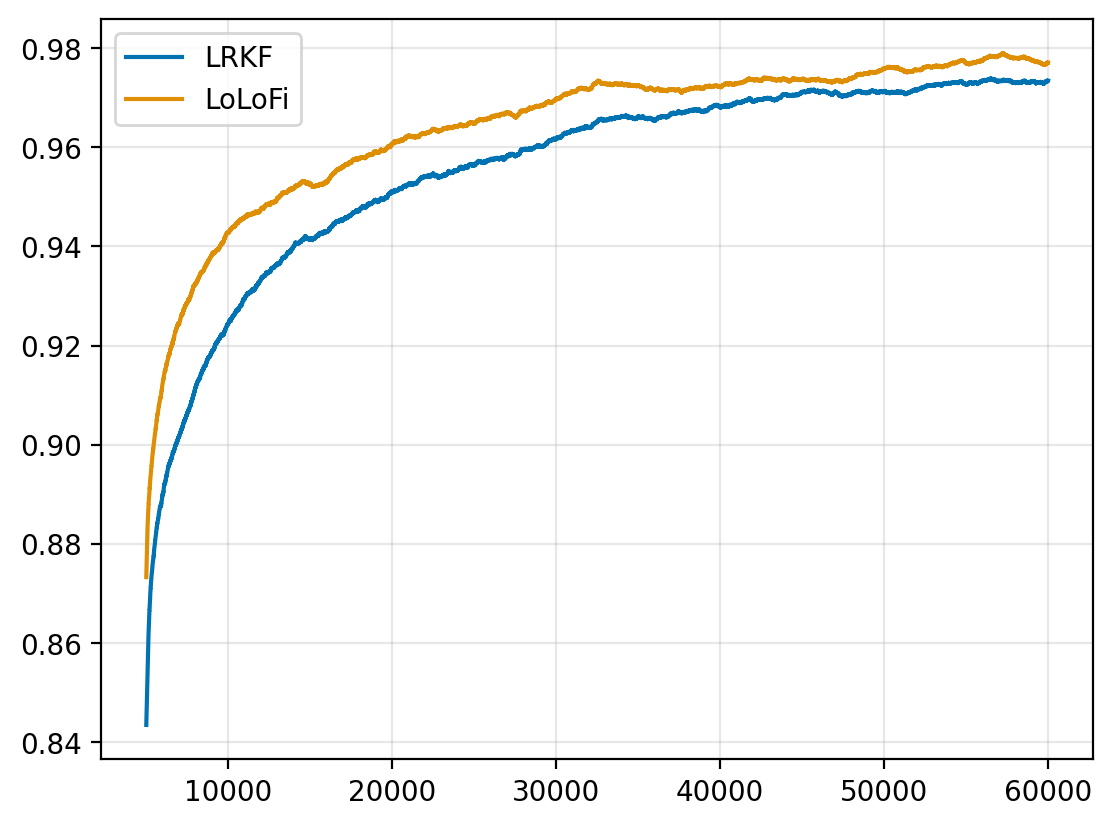

In [25]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plt.legend()
plt.grid(alpha=0.3)

## HiLoFi

In [26]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=1e-4):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [29]:
%%time
def run_hilofi(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = hilofi.LowRankLastLayer(
        mean_fn, cov_fn, rank=rank, rank_last=None,
        # dynamics_hidden=1e-6, dynamics_last=1e-6,
        dynamics_hidden=0.01, dynamics_last=0.01,
    )
    params = model.init(key, X_train[:100])
    
    bel_init = agent.init_bel(params, cov_hidden=1.0, cov_last=1.0, low_rank_diag=True)
    
    cfn = partial(callbackfn, agent=agent)
    bel_flores, hist_flores = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    
    return hist_flores

hist_hilofi = jax.vmap(run_hilofi)(keys)
hist_hilofi = jax.tree.map(np.array, hist_hilofi)

CPU times: user 54 s, sys: 1.3 s, total: 55.3 s
Wall time: 12min 32s


In [30]:
df_hilofi = pd.DataFrame(hist_hilofi.T)
df_hilofi.shape

(60000, 10)

CPU times: user 112 ms, sys: 3.99 ms, total: 116 ms
Wall time: 115 ms


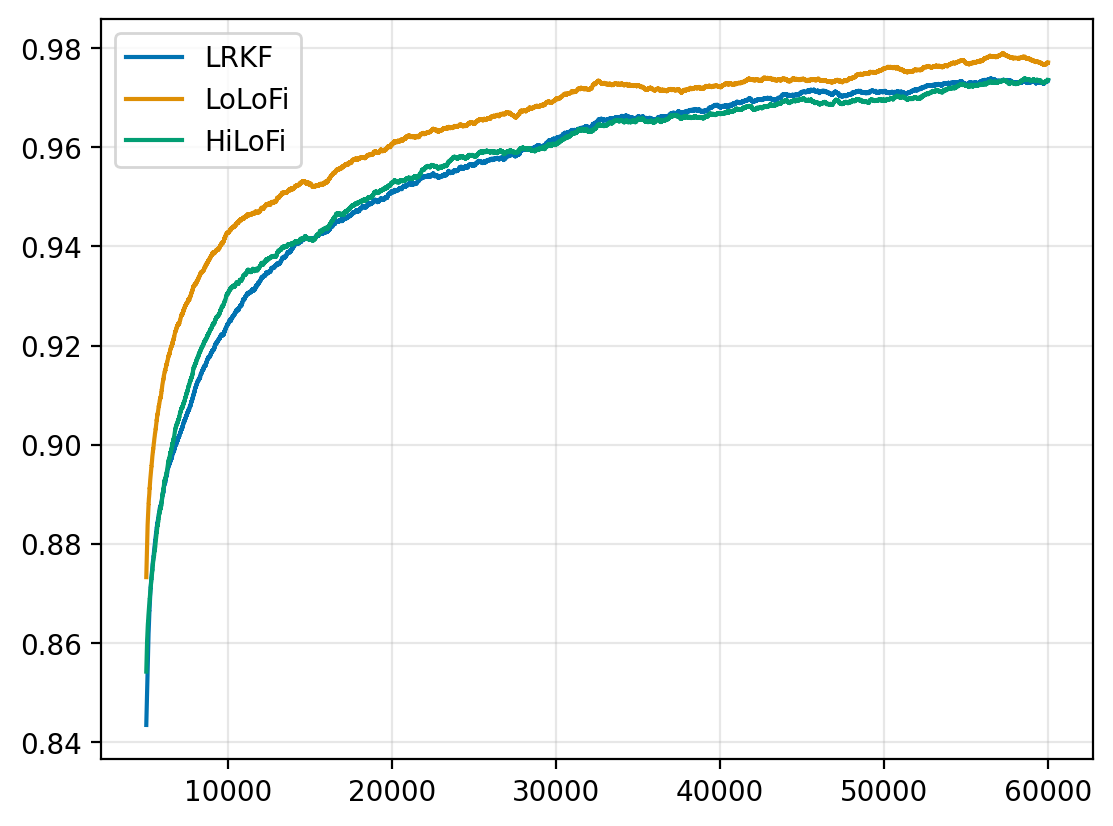

In [31]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_hilofi, ax, "HiLoFi")
plt.legend()
plt.grid(alpha=0.3)

## Low-rank (precision) filter (LoFi)

In [32]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.01):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [33]:
%%time

def run_lofi(key, rank=50):
    key_init, key_shuffle = jax.random.split(key)
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    
    agent = lofi.LowRankPrecisionFilter(
        mean_fn, cov_fn, rank=rank, dynamics_covariance=0.0,
    )
    params = model.init(key_init, X_train[:100])
    
    bel_init = agent.init_bel(params, cov=jnp.exp(-8))
    
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lofi = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_lofi

hist_lofi = jax.vmap(run_lofi)(keys)
hist_lofi = jax.tree.map(np.array, hist_lofi)

CPU times: user 37.6 s, sys: 1.4 s, total: 39 s
Wall time: 6min 37s


In [34]:
df_lofi = pd.DataFrame(hist_lofi.T)
df_lofi.shape

(60000, 10)

CPU times: user 112 ms, sys: 3.98 ms, total: 116 ms
Wall time: 115 ms


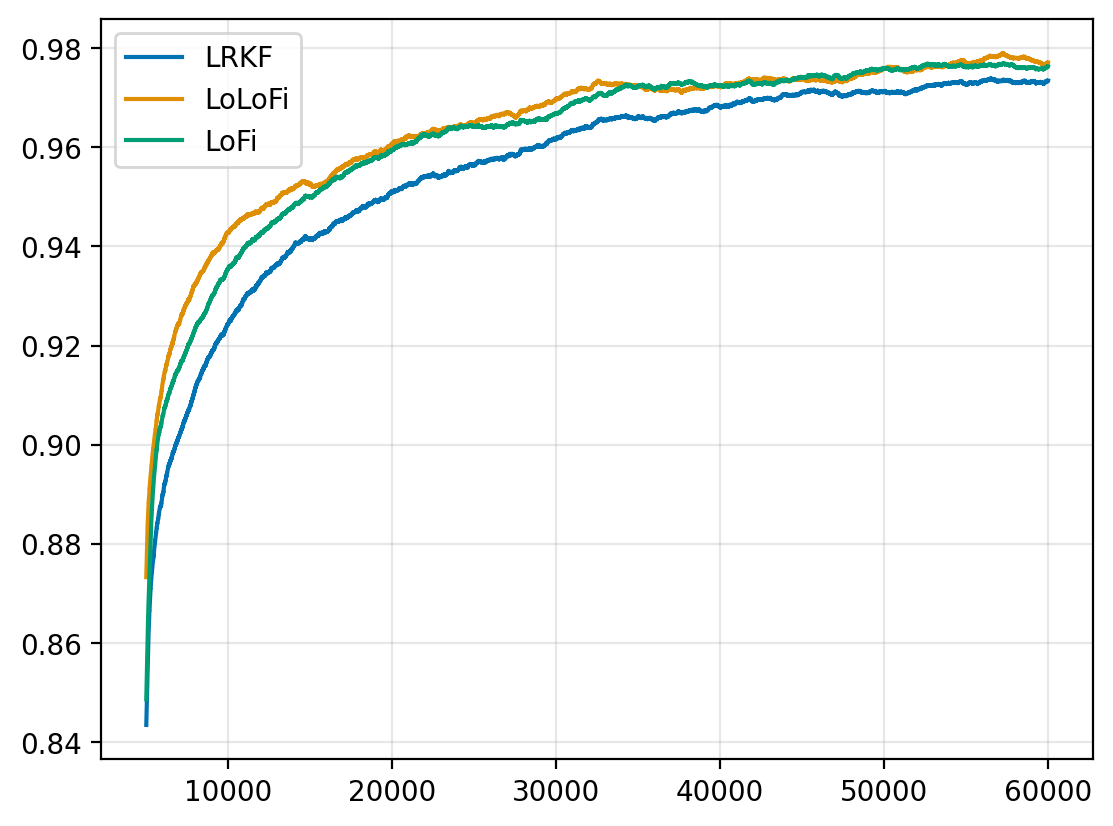

In [35]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_lofi, ax, "LoFi")
plt.legend()
plt.grid(alpha=0.3)

## Muon Shampoo

In [36]:
from methods import replay_sgd

In [37]:
def lossfn(params, counter, X, y, fn):
    yhat = fn(params, X)
    loss = optax.losses.softmax_cross_entropy(yhat, y)
    return (loss * counter).sum() / counter.sum()

In [38]:
%%time

def run_muon(key):
    key_init, key_shuffle = jax.random.split(key)
    
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    params = model.init(key_init, X_train[:100])
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        tx=optax.contrib.muon(learning_rate=1e-3),
        buffer_size=1,
        dim_features=(28, 28, 1),
        dim_output=10
    )
    
    cfn = partial(callbackfn, agent=agent)
    bel_init = agent.init_bel(params)
    bel_muon, hist_muon = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist_muon

hist_muon = jax.vmap(run_muon)(keys)
hist_muon = jax.tree.map(np.array, hist_muon)

CPU times: user 12.8 s, sys: 198 ms, total: 13 s
Wall time: 31 s


In [39]:
df_muon = pd.DataFrame(hist_muon.T)
df_muon.shape

(60000, 10)

CPU times: user 182 ms, sys: 0 ns, total: 182 ms
Wall time: 181 ms


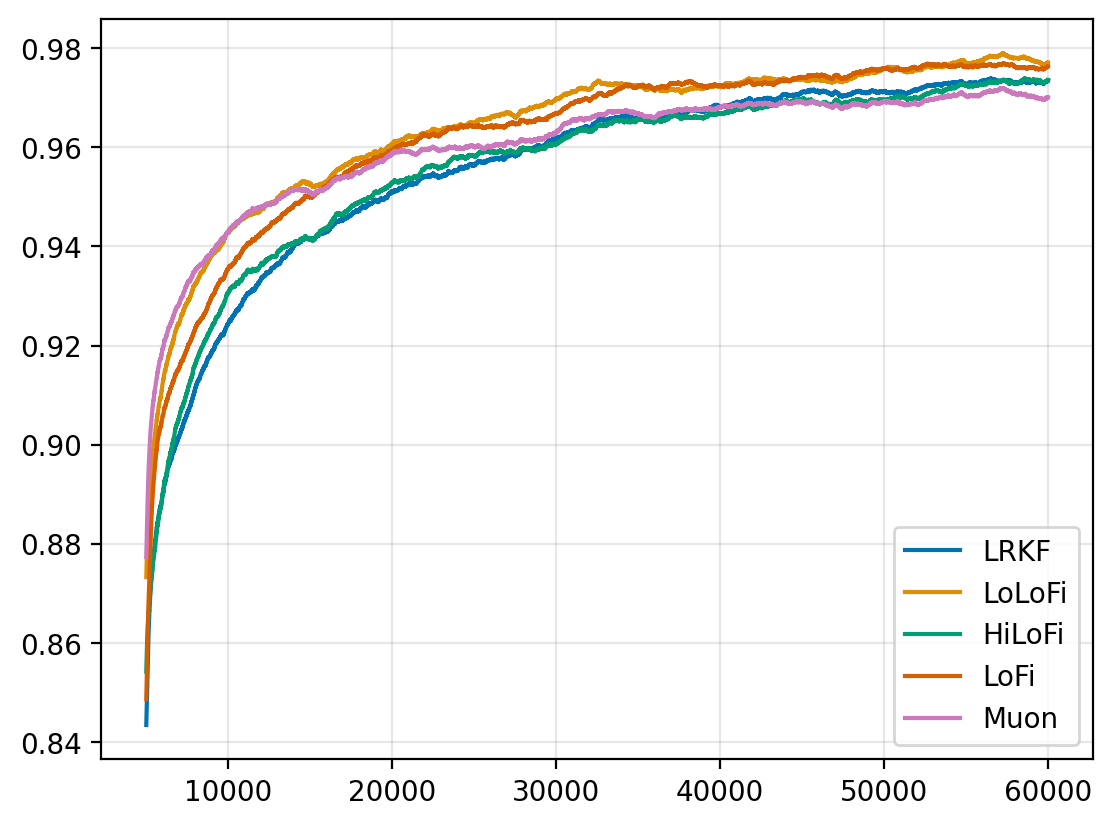

In [40]:
%%time
fig, ax = plt.subplots()
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_hilofi, ax, "HiLoFi")
plot_err_bound(df_lofi, ax, "LoFi")
plot_err_bound(df_muon, ax, "Muon")
plt.legend()
plt.grid(alpha=0.3)

## Adamw

In [41]:
%%time
def run_adamw(key):
    key_init, key_shuffle = jax.random.split(key)
    
    ix_choice = jax.random.choice(key_shuffle, n_obs, (n_obs,), replace=False)
    params = model.init(key_init, X_train[:100])
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        tx=optax.adamw(learning_rate=1e-4),
        buffer_size=5,
        dim_features=(28, 28, 1),
        dim_output=10
    )
    
    cfn = partial(callbackfn, agent=agent)
    bel_init = agent.init_bel(params)
    bel, hist = agent.scan(
        bel_init,
        y_train.at[ix_choice].get(),
        X_train.at[ix_choice].get(),
        cfn
    )
    return hist
    
hist_adamw = jax.vmap(run_adamw)(keys)
hist_adamw = jax.tree.map(np.array, hist_adamw)

CPU times: user 16.8 s, sys: 133 ms, total: 16.9 s
Wall time: 55.2 s


In [42]:
df_adamw = pd.DataFrame(hist_adamw.T)
df_adamw.shape

(60000, 10)

## Plot all results

In [43]:
def plot_err_bound(df, ax, label, periods=5000, min_periods=None):
    min_periods = periods if min_periods is None else min_periods
    df.rolling(periods, min_periods=min_periods).mean().mean(axis=1).plot(label=label, ax=ax)
    lbound = df.rolling(periods, min_periods=min_periods).mean().quantile(0.25, axis=1)
    ubound = df.rolling(periods, min_periods=min_periods).mean().quantile(0.75, axis=1)
    ax.fill_between(lbound.index, lbound, ubound, alpha=0.4)

CPU times: user 42.6 s, sys: 346 ms, total: 42.9 s
Wall time: 42.8 s


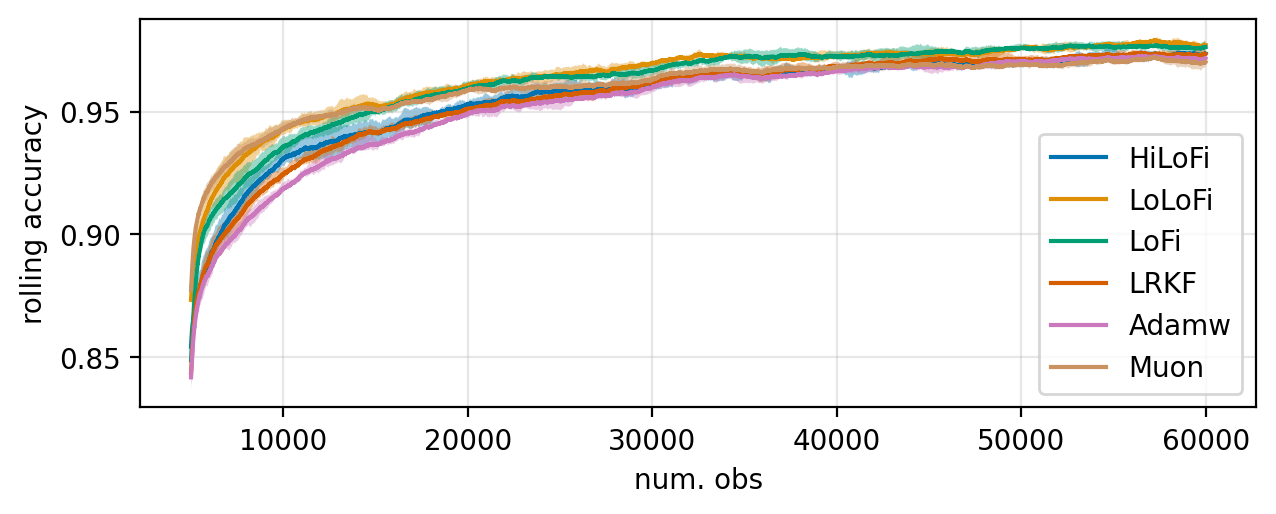

In [44]:
%%time
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.6))
plot_err_bound(df_hilofi, ax, "HiLoFi")
plot_err_bound(df_lolofi, ax, "LoLoFi")
plot_err_bound(df_lofi, ax, "LoFi")
plot_err_bound(df_lrkf, ax, "LRKF")
plot_err_bound(df_adamw, ax, "Adamw")
plot_err_bound(df_muon, ax, "Muon")
plt.legend()
plt.ylabel("rolling accuracy")
plt.xlabel("num. obs")
plt.grid(alpha=0.3)
plt.savefig("../figures/mnist-online-classification.png", dpi=300, bbox_inches="tight")